In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import nltk
import re
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from time import time
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pprint import pprint

# Motivation
A low Number of topics results in too few or very broad topics, whereas a high number of topics results in uninterpretable topics or topics that ideally should  have  been  merged.  Choosing  the  right  value  of  topics  is thus an important task in topic modeling algorithms. Researchers have proposed topic **coherence** measures. The idea behind is that words with similar meanings tend to occur in similar contexts. The topics are considered to be coherent if all or most of the words, for example, the topic’s top N words, are related.
Source Paper: http://www.saf21.eu/wp-content/uploads/2017/09/5004a165.pdf

# Corpus and dictionary

In [2]:
df = pd.read_pickle("../data/cleaned_df")

In [3]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
# words from the wordcloud
stop_words.extend(['thank', 'please', 'whats', 'thanks', 'email', 'would', 'us', 'will', 'address', 
                   'question', 'questions', 'many', 'must', 'could', 'should'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARosa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def stemming(docs):
    porter_stemmer=nltk.PorterStemmer()
    return [[porter_stemmer.stem(word) for word in doc] for doc in docs]

# simple_preprocess: it lowercases, tokenizes, de-accents (optional) with deacc
def extract_words(questions):
    for q in questions:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(q), deacc=True))
        
def remove_stopwords(docs):
    # docs is a list of document. A document being a list of words
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in docs]

def remove_empty_list(docs):
    return [doc for doc in docs if len(doc)>0]                

In [6]:
data = df.cleaned.values.tolist()
corpus = list(extract_words(data))
corpus_sw = remove_stopwords(corpus)
final_corpus = remove_empty_list(corpus_sw)
final_corpus_stem = stemming(final_corpus)

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(final_corpus_stem)

In [8]:
# Convert document (a list of words) into the bag-of-words
# Each word is assumed to be a tokenized and normalized ( (either unicode or utf8-encoded).)
corpus = [id2word.doc2bow(doc) for doc in final_corpus_stem]

Now we are ready with the same corpus as the initial exploration.

# Find optimal number of topics using coherence


Let's train multiple LDA models and select the one with the highest coherence score. We will use *U_mass* coherence. It is calculated over the log of probabilities therefore it is negative.

In [17]:
def u_mass_coherence_values_computation(dictionary, corpus, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       alpha='auto',
                                       eta='auto',
                                       num_topics=num_topics,
                                       random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

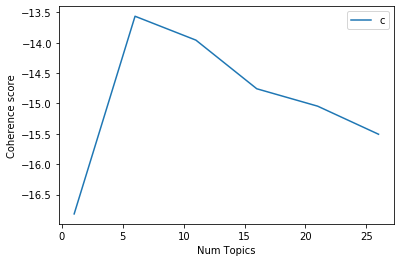

In [18]:
model_list, coherence_values = u_mass_coherence_values_computation (dictionary=id2word, corpus=corpus,
                                                             start=1, limit=30, step=5)
limit=30; start=1; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 1  is having Coherence Value of -16.8197
Num Topics = 6  is having Coherence Value of -13.565
Num Topics = 11  is having Coherence Value of -13.9584
Num Topics = 16  is having Coherence Value of -14.7591
Num Topics = 21  is having Coherence Value of -15.0457
Num Topics = 26  is having Coherence Value of -15.5078


# LDA 6 Topics

In [23]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.211*"strongif" + 0.053*"name" + 0.032*"notstrong" + 0.028*"use" + '
  '0.017*"want" + 0.014*"time" + 0.012*"comment" + 0.012*"number" + '
  '0.009*"compani" + 0.008*"first"'),
 (1,
  '0.159*"like" + 0.075*"softwar" + 0.075*"appear" + 0.071*"home" + '
  '0.070*"use" + 0.070*"want" + 0.070*"usual" + 0.059*"page" + '
  '0.049*"notstrong" + 0.033*"often"'),
 (2,
  '0.234*"say" + 0.012*"like" + 0.010*"interest" + 0.010*"share" + '
  '0.009*"provid" + 0.008*"anyth" + 0.008*"one" + 0.008*"help" + 0.007*"els" + '
  '0.007*"project"'),
 (3,
  '0.213*"item" + 0.033*"page" + 0.010*"take" + 0.009*"answer" + '
  '0.008*"feedback" + 0.007*"survey" + 0.007*"like" + 0.007*"want" + '
  '0.007*"appreci" + 0.007*"think"'),
 (4,
  '0.111*"think" + 0.111*"click" + 0.111*"handl" + 0.111*"success" + '
  '0.110*"twitter" + 0.064*"often" + 0.011*"item" + 0.010*"like" + '
  '0.008*"usual" + 0.007*"page"'),
 (5,
  '0.159*"requir" + 0.159*"littl" + 0.123*"dietari" + 0.013*"much" + '
  '0.010*"use" + 0.0

In [25]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import os
def generate_html_vis_file(model, num_topics, id2word, corpus):
    # Visualize the topics
    pyLDAvis.enable_notebook()
    LDAvis_filepath = os.path.join('../data/ldavis_'+str(num_topics)+'_topics')
    
    # feed the LDA model into the pyLDAvis instance
    LDAvis_prepared = gensimvis.prepare(model, corpus, id2word)
    with open(LDAvis_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)
    with open(LDAvis_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, '../data/ldavis_'+ str(num_topics)+'_topics' +'.html')

In [26]:
generate_html_vis_file(optimal_model, 6, id2word, corpus)

# Dominant topic per question

In [30]:
def dominant_topics(ldamodel, corpus, texts):
    q_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                q_topics_df = q_topics_df.append(
                pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    q_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    q_topics_df = pd.concat([q_topics_df, contents], axis=1)
    return(q_topics_df)

In [31]:
df_topic_sents_keywords = dominant_topics(optimal_model, corpus, final_corpus_stem)

In [32]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
   'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text'
]

In [33]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.6187,"think, click, handl, success, twitter, often, ...",[firstnam]
1,1,5.0,0.8127,"requir, littl, dietari, much, use, like, proje...","[get, irrit, easili]"
2,2,0.0,0.6092,"strongif, name, notstrong, use, want, time, co...",[comment]
3,3,2.0,0.8079,"say, like, interest, share, provid, anyth, one...","[let, survey, exercis]"
4,4,1.0,0.7496,"like, softwar, appear, home, use, want, usual,...","[like, design]"
5,5,2.0,0.7420,"say, like, interest, share, provid, anyth, one...","[part, contact, surpris, soon]"
6,6,4.0,0.5662,"think, click, handl, success, twitter, often, ...","[ever, paid, servic, like]"
7,7,2.0,0.8081,"say, like, interest, share, provid, anyth, one...","[type, servic, interest]"
8,8,2.0,0.8070,"say, like, interest, share, provid, anyth, one...","[recommend, indivirtu, client]"
9,9,2.0,0.8082,"say, like, interest, share, provid, anyth, one...","[select, bunch, stuff]"


## Topic distribution of documents

In [35]:
def topics_doc_to_df(topics_doc, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_doc:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

def get_docs_dist_per_topic(model, corpus, num_topics):
    topics = [model[corpus[i]] for i in range(len(corpus))]
    # topic weighting matrix
    topics_df = pd.concat([topics_doc_to_df(topics_doc, num_topics) 
                                for topics_doc in topics]).reset_index(drop=True).fillna(0)
    return topics_df

In [36]:
topics6_df = get_docs_dist_per_topic(optimal_model, corpus, 6)

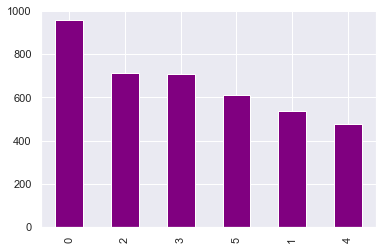

In [38]:
import seaborn as sns
sns.set(style="darkgrid", palette="viridis")
topics6_df.idxmax(axis=1).value_counts().plot.bar(color='purple')

## Conclusion

We found a way to select the best number of topics according to a mathematical coherence model. The next step would be to get the domain knowledge experts so that they can explore the topics and confirm if they are relevant or not. Besides they should give a name to each category.